<a href="https://colab.research.google.com/github/SherryKu/Huamn_VS_AI_Text_Detection_Project/blob/main/VNN_FNN_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EDA

## Preparing the ground <a id="1.1"></a>

### Install and import necessary packages

In [ ]:
!pip install -q pyicu
!pip install -q pycld2
!pip install -q polyglot
!pip install -q textstat
!pip install -q googletrans
!pip install colorama
!pip3 install pyicu
!pip3 install pycld2
!pip3 install morfessor
!pip install datasets

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import os
import gc
import re
import folium
import textstat
from scipy import stats
from colorama import Fore, Back, Style, init

import math
import numpy as np
import scipy as sp
import pandas as pd

import random
import networkx as nx
from pandas import Timestamp

from PIL import Image
from IPython.display import SVG
from keras.utils import model_to_dot

import requests
from IPython.display import HTML

import seaborn as sns
from tqdm import tqdm
import matplotlib.cm as cm
import matplotlib.pyplot as plt

tqdm.pandas()

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

import transformers
import tensorflow as tf

from tensorflow.keras.callbacks import Callback
from sklearn.metrics import accuracy_score, roc_auc_score
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tokenizers import BertWordPieceTokenizer
from tensorflow.keras.layers import Dense, Input, Dropout, Embedding
from tensorflow.keras.layers import LSTM, GRU, Conv1D, SpatialDropout1D

from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import activations
from tensorflow.keras import constraints
from tensorflow.keras import initializers
from tensorflow.keras import regularizers

import tensorflow.keras.backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.activations import *
from tensorflow.keras.constraints import *
from tensorflow.keras.initializers import *
from tensorflow.keras.regularizers import *

from sklearn import metrics
from sklearn.utils import shuffle
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer,\
                                            CountVectorizer,\
                                            HashingVectorizer

from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer

import nltk
from textblob import TextBlob

from nltk.corpus import wordnet
from nltk.corpus import stopwords
from googletrans import Translator
from nltk import WordNetLemmatizer
from polyglot.detect import Detector
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS
from nltk.sentiment.vader import SentimentIntensityAnalyzer

stopword=set(STOPWORDS)

lem = WordNetLemmatizer()
tokenizer=TweetTokenizer()

np.random.seed(0)

### Load the training, validation, and testing datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from datasets import load_dataset
dataset = load_dataset("Hello-SimpleAI/HC3", name='all')
dataset1 = dataset['train'].to_pandas()
dataset1

def process_dataset(dataset):
    human = dataset[['human_answers']].rename(columns={'human_answers':'text'})
    human['text'] = human['text'].apply(lambda x: ''.join(x))
    human['generated'] = 0

    ai = dataset[['chatgpt_answers']].rename(columns={'chatgpt_answers':'text'})
    ai['text'] = ai['text'].apply(lambda x: ''.join(x))
    ai['generated'] = 1

    clean_data = pd.concat((human, ai), axis=0, ignore_index=True)

    clean_data = clean_data[clean_data['text'] != '']

    return clean_data

data1 = process_dataset(dataset1)

In [ ]:
dataset2 = pd.read_csv("/content/drive/MyDrive/DS301GroupProject/train_v2_drcat_02.csv")
def process_dataset2(dataset):
    dataset.drop(['prompt_name', 'source', 'RDizzl3_seven'], axis=1, inplace=True)
    dataset.rename(columns={'label': 'generated'}, inplace=True)
    return dataset

data2 = process_dataset2(dataset2)

In [ ]:
def clean(text):
    text = text.fillna("fillna").str.lower()
    text = text.map(lambda x: re.sub('\\n',' ',str(x)))
    text = text.map(lambda x: re.sub("\[\[User.*",'',str(x)))
    text = text.map(lambda x: re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}",'',str(x)))
    text = text.map(lambda x: re.sub("\(http://.*?\s\(http://.*\)",'',str(x)))
    return text

data1["text"] = clean(data1["text"])
data2["text"] = clean(data2["text"])

In [ ]:
data = pd.concat([data1, data2], ignore_index=True)
data

,text,generated
0,"basically there are many categories of "" best ...",0
1,salt is good for not dying in car crashes and ...,0
2,the way it works is that old tv stations got a...,0
3,you ca n't just go around assassinating the le...,0
4,wanting to kill the shit out of germans drives...,0
...,...,...
93050,"dear senator, i am writing to you today to ex...",1
93051,"dear senator, i am writing to you today to ex...",1
93052,"dear senator, i am writing to you today to ex...",1
93053,"dear senator, i am writing to you today to ex...",1


# Modeling Preparation

## Preparing the ground <a id="2.1"></a>

### Define ROC-AUC evaluation metric

In [ ]:
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: {:d} - score: {:.6f}".format(epoch+1, score))

### DistilBert

#### Define function to tokenize (encode) comments

In [ ]:
def fast_encode(texts, tokenizer, chunk_size=240, maxlen=512):
    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(max_length=maxlen)
    all_ids = []

    for i in range(0, len(texts), chunk_size):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])

    return np.array(all_ids)

#### Load BERT tokenizer

In [ ]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('distilbert-base-uncased')
tokenizer.save_pretrained('./distilbert_base_uncased_tokenizer/')

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.


('./distilbert_base_uncased_tokenizer/tokenizer_config.json',
 './distilbert_base_uncased_tokenizer/special_tokens_map.json',
 './distilbert_base_uncased_tokenizer/vocab.txt',
 './distilbert_base_uncased_tokenizer/added_tokens.json')

#### Encode comments and get targets

In [ ]:
from transformers import BertTokenizer
def fast_encode(texts, tokenizer, maxlen=512):
    encoded = tokenizer.batch_encode_plus(
        texts,
        return_attention_mask=False,
        return_token_type_ids=False,
        pad_to_max_length=True,
        max_length=maxlen,
        truncation=True
    )

    return np.array(encoded['input_ids'])

In [ ]:
data_encoded = fast_encode(data.text.astype(str), tokenizer, maxlen=512)

In [ ]:
encoded_texts_bert = data_encoded

In [ ]:
import csv
filename = 've_distilbert-base-uncased_data.csv'

# Writing to the CSV file
with open(filename, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(data_encoded)

print(f'{filename} has been created and exported successfully.')

ve_distilbert-base-uncased_data.csv has been created and exported successfully.


### GloVe

#### Load Required GloVe Embeddings

In [ ]:
def load_required_glove_embeddings(path, required_words):
    embeddings_index = {}
    with open(path, 'r', encoding='utf-8') as file:
        for line in file:
            values = line.split()
            word = values[0]
            if word in required_words:
                vector = np.asarray(values[1:], dtype='float32')
                embeddings_index[word] = vector
    return embeddings_index

#### Encode commets and get targets

In [ ]:
import urllib.request
import zipfile
import os

glove_url = "http://nlp.stanford.edu/data/glove.6B.zip"
glove_zip_path = "glove.6B.zip"

if not os.path.exists(glove_zip_path):
    urllib.request.urlretrieve(glove_url, glove_zip_path)

with zipfile.ZipFile(glove_zip_path, 'r') as z:
    z.extractall("glove")

In [ ]:
all_words = set()
for text in data['text']:
    all_words.update(text.lower().split())

glove_path = 'glove/glove.6B.50d.txt'
required_glove = load_required_glove_embeddings(glove_path, all_words)

In [ ]:
import numpy as np

def glove_fast_encode(texts, glove_embeddings, max_length=100):
    encoded_texts = []
    vector_dim = 50

    for text in texts:
        words = text.lower().split()
        word_vectors = [glove_embeddings[word] for word in words if word in glove_embeddings][:max_length]
        if word_vectors:
            encoded_texts.append(np.array(word_vectors, dtype=float))
        else:
            encoded_texts.append(np.zeros((1, vector_dim), dtype=float))

    actual_max_length = min(max(len(text) for text in encoded_texts), max_length)

    padded_texts = [np.pad(text,
                           pad_width=((0, actual_max_length - len(text)), (0, 0)),
                           mode='constant',
                           constant_values=0) for text in encoded_texts]

    return np.stack(padded_texts)

max_length = 100
encoded_texts_glove = glove_fast_encode(data['text'].tolist(), required_glove, max_length=max_length)

In [ ]:
import csv
filename = 've_glove.6B.50d_data.csv'

with open(filename, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(encoded_texts_glove)

print(f'{filename} has been created and exported successfully.')

In [ ]:
from google.colab import files
files.download('ve_glove.6B.50d_data.csv')

In [ ]:
encoded_texts_glove = pd.read_csv("/content/drive/MyDrive/DS301GroupProject/ve_glove.6B.50d_data.csv")

### Define training, validation, and testing datasets

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(encoded_texts_glove, data['generated'], test_size=0.2, random_state=1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=1)

In [ ]:
BATCH_SIZE = 32
AUTO = tf.data.experimental.AUTOTUNE

In [ ]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_train, y_train))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_val, y_val))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(x_test)
    .batch(BATCH_SIZE)
)

# Model Tested on Bert Tokenization

## Vanilla neural network

### Define VNN model

In [ ]:
def build_vnn_model(transformer, max_len):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")

    embed = transformer.weights[0].numpy()
    embedding = Embedding(np.shape(embed)[0], np.shape(embed)[1],
                          input_length=max_len, weights=[embed],
                          trainable=False)(input_word_ids)

    conc = K.sum(embedding, axis=2)
    conc = Dense(128, activation='relu')(conc)
    conc = Dense(1, activation='sigmoid')(conc)

    model = Model(inputs=input_word_ids, outputs=conc)

    model.compile(Adam(lr=0.01),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

### Build model and check summary

In [ ]:
import tensorflow as tf

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print("Running on TPU:", tpu.master())
except ValueError:
    print("Could not connect to TPU")
    tpu = None

Could not connect to TPU


In [ ]:
strategy = tf.distribute.OneDeviceStrategy(device="/cpu:0")
with strategy.scope():
    transformer_layer = transformers.TFDistilBertModel.\
    from_pretrained('distilbert-base-multilingual-cased')
    model_vnn = build_vnn_model(transformer_layer, max_len=512)

model_vnn.summary()

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_word_ids (InputLayer  [(None, 512)]             0         
 )                                                               
                                                                 
 embedding (Embedding)       (None, 512, 768)          91812096  
                                                                 
 tf.math.reduce_sum (TFOpLa  (None, 512)               0         
 mbda)                                                           
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 91877889 (350.49 MB)
Trainable params: 65793 (2

### Visualize network architecture

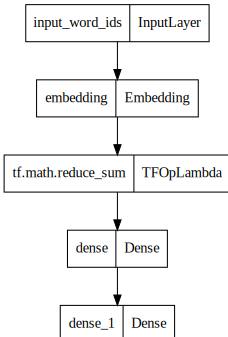

In [ ]:
SVG(tf.keras.utils.model_to_dot(model_vnn, dpi=70).create(prog='dot', format='svg'))

### Define ReduceLROnPlateau callback

In [ ]:
def callback():
    cb = []

    reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss',
                                    factor=0.3, patience=3,
                                    verbose=1, mode='auto',
                                    epsilon=0.0001, cooldown=1, min_lr=0.000001)
    cb.append(reduceLROnPlat)
    log = CSVLogger('log.csv')
    cb.append(log)

    RocAuc = RocAucEvaluation(validation_data=(x_val, y_val), interval=1)
    cb.append(RocAuc)

    return cb

### Train the model

In [ ]:
N_STEPS = x_train.shape[0] // BATCH_SIZE
calls = callback()
EPOCHS = 10

train_history = model_vnn.fit(
    train_dataset,
    steps_per_epoch=N_STEPS,
    callbacks = calls,
    epochs=EPOCHS
)

Epoch 1/10
1744/1744 [==============================] - ETA: 0s - loss: 0.7591 - accuracy: 0.6100


 ROC-AUC - epoch: 1 - score: 0.705137
1744/1744 [==============================] - 32s 18ms/step - loss: 0.7591 - accuracy: 0.6100 - lr: 0.0010
Epoch 2/10
1741/1744 [============================>.] - ETA: 0s - loss: 0.6195 - accuracy: 0.6423


 ROC-AUC - epoch: 2 - score: 0.710473
1744/1744 [==============================] - 31s 18ms/step - loss: 0.6195 - accuracy: 0.6423 - lr: 0.0010
Epoch 3/10
1741/1744 [============================>.] - ETA: 0s - loss: 0.6150 - accuracy: 0.6461


 ROC-AUC - epoch: 3 - score: 0.709967
1744/1744 [==============================] - 30s 17ms/step - loss: 0.6149 - accuracy: 0.6461 - lr: 0.0010
Epoch 4/10
1743/1744 [============================>.] - ETA: 0s - loss: 0.6127 - accuracy: 0.6475


 ROC-AUC - epoch: 4 - score: 0.703699
1744/1744 [==============================] - 31s 18ms/step - loss: 0.6127 - accuracy: 0.6475 - lr: 0.0010
Epoch 5/10
1743/1744 [============================>.] - ETA: 0s - loss: 0.6111 - accuracy: 0.6513


 ROC-AUC - epoch: 5 - score: 0.709908
1744/1744 [==============================] - 35s 20ms/step - loss: 0.6112 - accuracy: 0.6513 - lr: 0.0010
Epoch 6/10
1741/1744 [============================>.] - ETA: 0s - loss: 0.6087 - accuracy: 0.6539


 ROC-AUC - epoch: 6 - score: 0.710768
1744/1744 [==============================] - 35s 20ms/step - loss: 0.6088 - accuracy: 0.6540 - lr: 0.0010
Epoch 7/10
1742/1744 [============================>.] - ETA: 0s - loss: 0.6065 - accuracy: 0.6569


 ROC-AUC - epoch: 7 - score: 0.712407
1744/1744 [==============================] - 33s 19ms/step - loss: 0.6066 - accuracy: 0.6568 - lr: 0.0010
Epoch 8/10
1743/1744 [============================>.] - ETA: 0s - loss: 0.6049 - accuracy: 0.6579


 ROC-AUC - epoch: 8 - score: 0.711606
1744/1744 [==============================] - 31s 18ms/step - loss: 0.6049 - accuracy: 0.6579 - lr: 0.0010
Epoch 9/10
1743/1744 [============================>.] - ETA: 0s - loss: 0.6035 - accuracy: 0.6605


 ROC-AUC - epoch: 9 - score: 0.712692
1744/1744 [==============================] - 33s 19ms/step - loss: 0.6035 - accuracy: 0.6605 - lr: 0.0010
Epoch 10/10
1743/1744 [============================>.] - ETA: 0s - loss: 0.6027 - accuracy: 0.6613


 ROC-AUC - epoch: 10 - score: 0.712310
1744/1744 [==============================] - 30s 17ms/step - loss: 0.6027 - accuracy: 0.6613 - lr: 0.0010


### Visualize model predictions

In [ ]:
val_data = pd.DataFrame({
    'text': [tokenizer.decode(tokens, skip_special_tokens=True) for tokens in x_val],
    'label': y_val
})

In [ ]:
def visualize_model_preds(model, indices=[0, 17, 1, 24]):
    texts = val_data.text.iloc[indices].values.tolist()
    preds = model.predict(x_val[indices].reshape(len(indices), -1))

    for idx, i in enumerate(indices):
        label_indicator = y_val.iloc[i]
        label = "Human" if label_indicator == 0 else "AI"
        color = Fore.GREEN if label_indicator == 0 else Fore.RED
        symbol = '\u2714' if label_indicator == 0 else '\u2716'

        print('{}{} {}'.format(color, str(idx+1) + ". " + label, symbol))
        print(f'{Style.RESET_ALL}')
        print("ORIGINAL")
        print(texts[idx]); print("")

visualize_model_preds(model_vnn)

1/1 [==============================] - 0s 66ms/step
1. Human ✔

ORIGINAL
think of your sleep cycle as a roller coaster. you go up, you go down, you go up, you do gown, and you do that many many times during the night. deep sleep, light sleep, deep sleep, light sleep, etc... think of waking up like getting off the roller coaster. if you get off the roller coaster on the bottom near the ground, it's easy, safe, and you feel rejuvenated and fresh. if you try to get off at the top, you'll end up falling a long distance, hit the ground, and you will feel awful. it's important to try and time your alarm clock to wake you up at the proper point on the roller coaster. each " up and down " takes about 90 minutes, so try to schedule your wake up time so it's in an interval of 90 minutes from when you fell asleep. that should place you near the ground when you wake up. there are number of factors that could be involved, but three of the most common are : 1 ) * * sleep apnea * * typically needs a 

## Convolutional neural network

The same logic is implemented below using tf.keras.

### Define CNN model

In [ ]:
def build_cnn_model(transformer, max_len):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")

    embed = transformer.weights[0].numpy()
    embedding = Embedding(np.shape(embed)[0], np.shape(embed)[1],
                          input_length=max_len, weights=[embed],
                          trainable=False)(input_word_ids)

    embedding = SpatialDropout1D(0.3)(embedding)
    conv_1 = Conv1D(64, 2)(embedding)
    conv_2 = Conv1D(64, 3)(embedding)
    conv_3 = Conv1D(64, 4)(embedding)
    conv_4 = Conv1D(64, 5)(embedding)

    maxpool_1 = GlobalAveragePooling1D()(conv_1)
    maxpool_2 = GlobalAveragePooling1D()(conv_2)
    maxpool_3 = GlobalAveragePooling1D()(conv_3)
    maxpool_4 = GlobalAveragePooling1D()(conv_4)
    conc = concatenate([maxpool_1, maxpool_2, maxpool_3, maxpool_4], axis=1)

    conc = Dense(64, activation='relu')(conc)
    conc = Dense(1, activation='sigmoid')(conc)

    model = Model(inputs=input_word_ids, outputs=conc)

    model.compile(Adam(lr=0.01),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

### Build model and check summary

In [ ]:
with strategy.scope():
    model_cnn = build_cnn_model(transformer_layer, max_len=512)

model_cnn.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_word_ids (InputLayer  [(None, 512)]                0         []                            
 )                                                                                                
                                                                                                  
 embedding_1 (Embedding)     (None, 512, 768)             9181209   ['input_word_ids[0][0]']      
                                                          6                                       
                                                                                                  
 spatial_dropout1d (Spatial  (None, 512, 768)             0         ['embedding_1[0][0]']         
 Dropout1D)                                                                                 

### Visualize network architecture

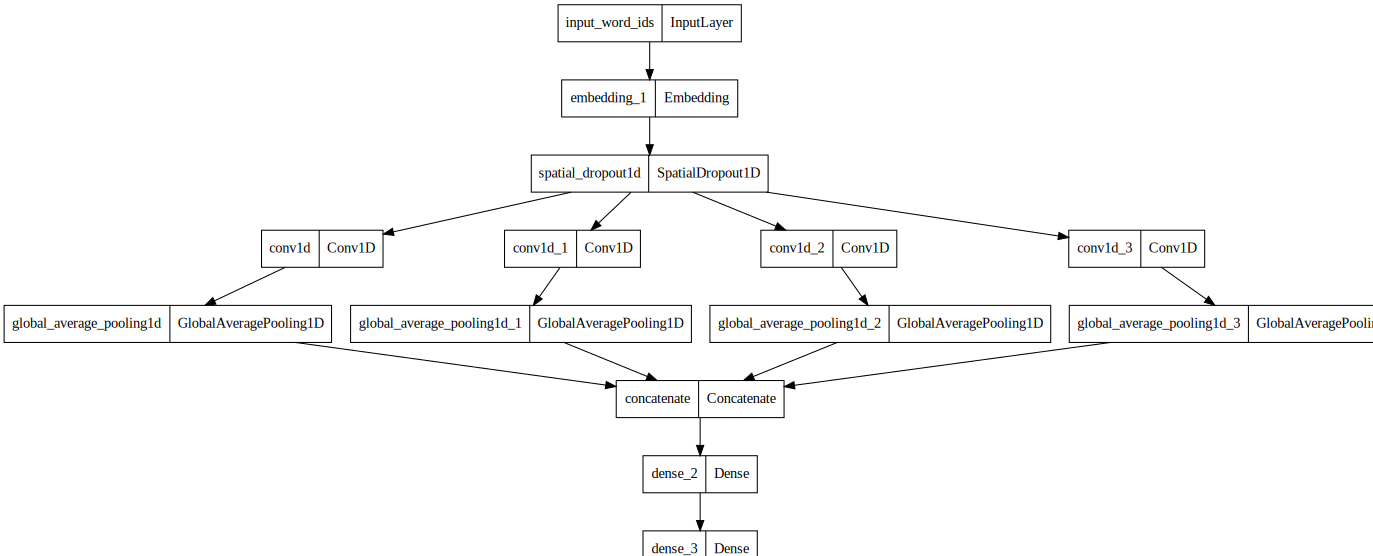

In [ ]:
SVG(tf.keras.utils.model_to_dot(model_cnn, dpi=70).create(prog='dot', format='svg'))

### Train the model

In [ ]:
N_STEPS = x_train.shape[0] // BATCH_SIZE
calls = callback()
EPOCHS = 2

train_history = model_cnn.fit(
    train_dataset,
    steps_per_epoch=N_STEPS,
    validation_data=valid_dataset,
    callbacks = calls,
    epochs=EPOCHS
)

Epoch 1/2
1744/1744 [==============================] - ETA: 0s - loss: 0.4719 - accuracy: 0.7651
 ROC-AUC - epoch: 1 - score: 0.934770
1744/1744 [==============================] - 591s 338ms/step - loss: 0.4719 - accuracy: 0.7651 - val_loss: 0.3731 - val_accuracy: 0.8194 - lr: 0.0010
Epoch 2/2
1744/1744 [==============================] - ETA: 0s - loss: 0.4085 - accuracy: 0.8146
 ROC-AUC - epoch: 2 - score: 0.945020
1744/1744 [==============================] - 617s 354ms/step - loss: 0.4085 - accuracy: 0.8146 - val_loss: 0.3207 - val_accuracy: 0.8780 - lr: 0.0010


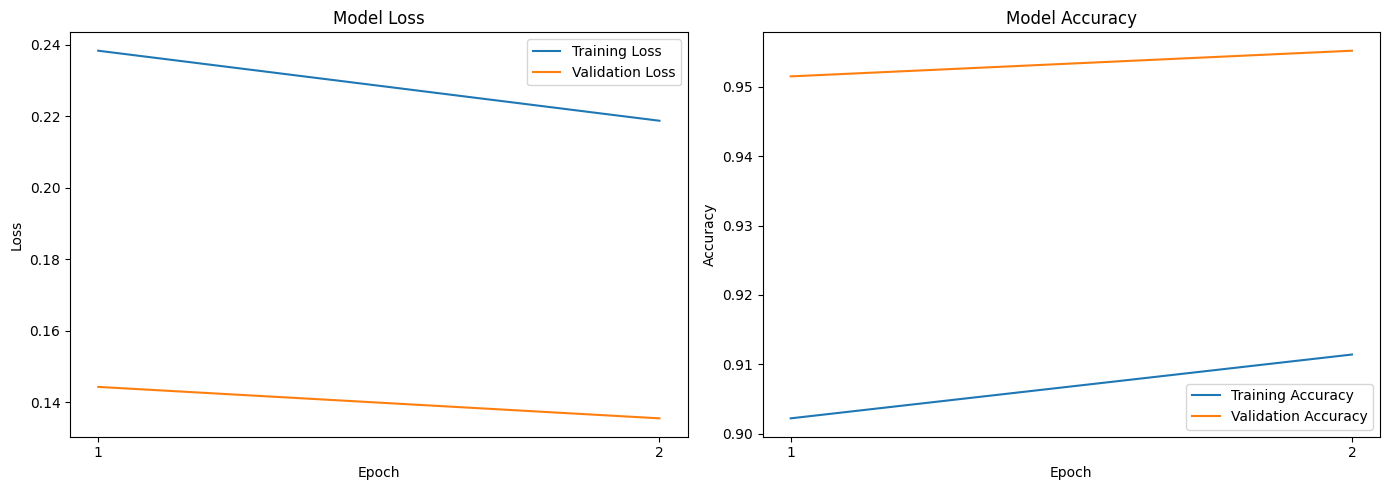

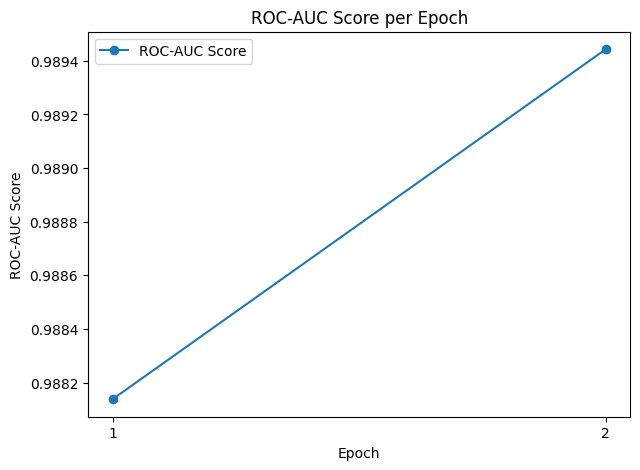

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

epochs = [1, 2]
training_loss = [0.2384, 0.2188]
validation_loss = [0.1443, 0.1355]
training_accuracy = [0.9022, 0.9114]
validation_accuracy = [0.9515, 0.9552]
roc_auc_scores = [0.988138, 0.989443]

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xticks(epochs)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, training_accuracy, label='Training Accuracy')
plt.plot(epochs, validation_accuracy, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xticks(epochs)
plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 5))
plt.plot(epochs, roc_auc_scores, label='ROC-AUC Score', marker='o')
plt.title('ROC-AUC Score per Epoch')
plt.ylabel('ROC-AUC Score')
plt.xlabel('Epoch')
plt.xticks(epochs)
plt.legend()
plt.show()


In [ ]:
model_path = '/content/drive/My Drive/DS301GroupProject/model_cnn'
model_cnn.save(model_path, save_format='tf')

In [ ]:
test_dataset

<_BatchDataset element_spec=TensorSpec(shape=(None, 512), dtype=tf.int64, name=None)>

In [ ]:
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(64)
test_loss, test_accuracy = model_cnn.evaluate(test_dataset)
print("Test loss:", test_loss)
print("Test accuracy:", test_accuracy)

291/291 [==============================] - 55s 187ms/step - loss: 0.3214 - accuracy: 0.8728
Test loss: 0.32144203782081604
Test accuracy: 0.8728171586990356


In [ ]:
test_predictions = model_cnn.predict(test_dataset)

582/582 [==============================] - 56s 96ms/step


In [ ]:
test_predictions

array([[0.6358132 ],
       [0.22555767],
       [0.84061277],
       ...,
       [0.02535123],
       [0.12982261],
       [0.316788  ]], dtype=float32)

### Visualize model predictions

In [ ]:
visualize_model_preds(model_cnn)

1/1 [==============================] - 0s 78ms/step
1. Human ✔

ORIGINAL
think of your sleep cycle as a roller coaster. you go up, you go down, you go up, you do gown, and you do that many many times during the night. deep sleep, light sleep, deep sleep, light sleep, etc... think of waking up like getting off the roller coaster. if you get off the roller coaster on the bottom near the ground, it's easy, safe, and you feel rejuvenated and fresh. if you try to get off at the top, you'll end up falling a long distance, hit the ground, and you will feel awful. it's important to try and time your alarm clock to wake you up at the proper point on the roller coaster. each " up and down " takes about 90 minutes, so try to schedule your wake up time so it's in an interval of 90 minutes from when you fell asleep. that should place you near the ground when you wake up. there are number of factors that could be involved, but three of the most common are : 1 ) * * sleep apnea * * typically needs a 

We can see the Conv1D model gives much more accurate predictions than the the VNN model. It predicts toxicity correctly for all four validation samples, because it is able to understand spatial relationships better.

# Model Tested on GloVe Tokenization

## Feedforward Neural Network #1

### Define Feedforward neural network model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Flatten
from tensorflow.keras.optimizers import Adam

def build_fnn_model(input_shape):
    input_layer = Input(shape=input_shape, dtype=tf.float64, name="input")

    flat = Flatten()(input_layer)

    conc = Dense(128, activation='relu')(flat)
    output = Dense(1, activation='sigmoid')(conc)

    model = Model(inputs=input_layer, outputs=output)
    model.compile(optimizer='Adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

### Build model and check summary

In [ ]:
model_fnn = build_fnn_model((100, 50))

In [ ]:
model_fnn.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 100, 50)]         0         
                                                                 
 flatten_2 (Flatten)         (None, 5000)              0         
                                                                 
 dense_6 (Dense)             (None, 128)               640128    
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 640257 (2.44 MB)
Trainable params: 640257 (2.44 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Visualize network architecture

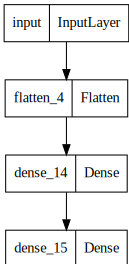

In [ ]:
SVG(tf.keras.utils.model_to_dot(model_fnn, dpi=70).create(prog='dot', format='svg'))

### Train the model

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
N_STEPS = x_train.shape[0] // BATCH_SIZE
EPOCHS = 10

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    verbose=1,
    min_lr=0.00001
)

train_history = model_fnn.fit(
    train_dataset,
    steps_per_epoch=N_STEPS,
    callbacks = [lr_scheduler],
    epochs=EPOCHS
)

Epoch 1/10
1731/1744 [============================>.] - ETA: 0s - loss: 0.4128 - accuracy: 0.8162

1744/1744 [==============================] - 6s 3ms/step - loss: 0.4118 - accuracy: 0.8167 - lr: 0.0010
Epoch 2/10
1736/1744 [============================>.] - ETA: 0s - loss: 0.2811 - accuracy: 0.8826

1744/1744 [==============================] - 6s 3ms/step - loss: 0.2809 - accuracy: 0.8827 - lr: 0.0010
Epoch 3/10
1741/1744 [============================>.] - ETA: 0s - loss: 0.2053 - accuracy: 0.9180

1744/1744 [==============================] - 6s 3ms/step - loss: 0.2052 - accuracy: 0.9181 - lr: 0.0010
Epoch 4/10
1741/1744 [============================>.] - ETA: 0s - loss: 0.1422 - accuracy: 0.9451

1744/1744 [==============================] - 6s 3ms/step - loss: 0.1422 - accuracy: 0.9451 - lr: 0.0010
Epoch 5/10
1728/1744 [============================>.] - ETA: 0s - loss: 0.0983 - accuracy: 0.9631

1744/1744 [==============================] - 5s 3ms/step - loss: 0.0981 - accuracy: 0.9632 - lr: 0.0010
Epoch 6/10
1740/1744 [============================>.] - ETA: 0s - loss: 0.0665 - accuracy: 0.9759

1744/1744 [==============================] - 5s 3ms/step - loss: 0.0665 - accuracy: 0.9759 - lr: 0.0010
Epoch 7/10
1740/1744 [============================>.] - ETA: 0s - loss: 0.0511 - accuracy: 0.9817

1744/1744 [==============================] - 6s 3ms/step - loss: 0.0510 - accuracy: 0.9818 - lr: 0.0010
Epoch 8/10
1736/1744 [============================>.] - ETA: 0s - loss: 0.0429 - accuracy: 0.9847

1744/1744 [==============================] - 6s 3ms/step - loss: 0.0429 - accuracy: 0.9847 - lr: 0.0010
Epoch 9/10
1730/1744 [============================>.] - ETA: 0s - loss: 0.0373 - accuracy: 0.9866

1744/1744 [==============================] - 5s 3ms/step - loss: 0.0371 - accuracy: 0.9867 - lr: 0.0010
Epoch 10/10
1734/1744 [============================>.] - ETA: 0s - loss: 0.0288 - accuracy: 0.9899

1744/1744 [==============================] - 5s 3ms/step - loss: 0.0287 - accuracy: 0.9900 - lr: 0.0010


## Feedforward Neural Network #2

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

def build_fnn_model(input_shape):
    input_layer = Input(shape=input_shape, dtype=tf.float64, name="input")
    flat = Flatten()(input_layer)
    dense_layer = Dense(128, activation='relu')(flat)
    output = Dense(1, activation='sigmoid')(dense_layer)
    model = Model(inputs=input_layer, outputs=output)
    model.compile(optimizer='Adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

BATCH_SIZE = 32
N_STEPS = x_train.shape[0] // BATCH_SIZE
EPOCHS = 10

model_fnn = build_fnn_model((100, 50))

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    verbose=1,
    min_lr=0.00001
)

train_history = model_fnn.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    steps_per_epoch=N_STEPS,
    epochs=EPOCHS,
    callbacks=[lr_scheduler]
)

test_loss, test_accuracy = model_fnn.evaluate(x_test, y_test)
print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))
print("Test Loss: {:.2f}".format(test_loss))

Epoch 1/10
1744/1744 [==============================] - 8s 4ms/step - loss: 0.4095 - accuracy: 0.8173 - val_loss: 0.3618 - val_accuracy: 0.8431 - lr: 0.0010
Epoch 2/10
1744/1744 [==============================] - 6s 4ms/step - loss: 0.2827 - accuracy: 0.8834 - val_loss: 0.3330 - val_accuracy: 0.8608 - lr: 0.0010
Epoch 3/10
1744/1744 [==============================] - 6s 4ms/step - loss: 0.2076 - accuracy: 0.9166 - val_loss: 0.3460 - val_accuracy: 0.8664 - lr: 0.0010
Epoch 4/10
1733/1744 [============================>.] - ETA: 0s - loss: 0.1459 - accuracy: 0.9435
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
1744/1744 [==============================] - 7s 4ms/step - loss: 0.1454 - accuracy: 0.9438 - val_loss: 0.3914 - val_accuracy: 0.8764 - lr: 0.0010
Epoch 5/10
1744/1744 [==============================] - 7s 4ms/step - loss: 0.0685 - accuracy: 0.9787 - val_loss: 0.3792 - val_accuracy: 0.8780 - lr: 1.0000e-04
Epoch 6/10
1737/1744 [=========================

582/582 [==============================] - 1s 2ms/step - loss: 0.4083 - accuracy: 0.8801
Test Accuracy: 88.01%
Test Loss: 0.41


## Feadforward Neural Network #3 with confusion matrix

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

def build_fnn_model(input_shape):
    input_layer = Input(shape=input_shape, dtype=tf.float64, name="input")
    flat = Flatten()(input_layer)
    dense_layer = Dense(128, activation='relu')(flat)
    output = Dense(1, activation='sigmoid')(dense_layer)
    model = Model(inputs=input_layer, outputs=output)
    model.compile(optimizer='Adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])
    return model

BATCH_SIZE = 32
N_STEPS = x_train.shape[0] // BATCH_SIZE
EPOCHS = 10

model_fnn = build_fnn_model((100, 50))

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    verbose=1,
    min_lr=0.00001
)

train_history = model_fnn.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    steps_per_epoch=N_STEPS,
    epochs=EPOCHS,
    callbacks=[lr_scheduler]
)

test_loss, test_accuracy, test_precision, test_recall = model_fnn.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.2f}")
print(f"Test Precision: {test_precision:.2f}")
print(f"Test Recall: {test_recall:.2f}")

y_pred = model_fnn.predict(x_test)
y_pred_classes = (y_pred > 0.5).astype("int32")

conf_matrix = confusion_matrix(y_test, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

class_report = classification_report(y_test, y_pred_classes, target_names=['Class 0', 'Class 1'])
print("Classification Report:")
print(class_report)

Epoch 1/10
1744/1744 [==============================] - 10s 5ms/step - loss: 0.4103 - accuracy: 0.8178 - precision: 0.8106 - recall: 0.7726 - val_loss: 0.3511 - val_accuracy: 0.8480 - val_precision: 0.8066 - val_recall: 0.8710 - lr: 0.0010
Epoch 2/10
1744/1744 [==============================] - 7s 4ms/step - loss: 0.2832 - accuracy: 0.8837 - precision: 0.8790 - recall: 0.8562 - val_loss: 0.3206 - val_accuracy: 0.8700 - val_precision: 0.8686 - val_recall: 0.8377 - lr: 0.0010
Epoch 3/10
1744/1744 [==============================] - 7s 4ms/step - loss: 0.2096 - accuracy: 0.9163 - precision: 0.9137 - recall: 0.8968 - val_loss: 0.3347 - val_accuracy: 0.8728 - val_precision: 0.8629 - val_recall: 0.8526 - lr: 0.0010
Epoch 4/10
1736/1744 [============================>.] - ETA: 0s - loss: 0.1538 - accuracy: 0.9400 - precision: 0.9388 - recall: 0.9258
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
1744/1744 [==============================] - 7s 4ms/step - loss: 0.153

582/582 [==============================] - 2s 3ms/step - loss: 0.3933 - accuracy: 0.8799 - precision: 0.8585 - recall: 0.8666
Test Accuracy: 87.99%
Test Loss: 0.39
Test Precision: 0.86
Test Recall: 0.87
582/582 [==============================] - 1s 2ms/step
Confusion Matrix:
[[9360 1156]
 [1080 7015]]
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.90      0.89      0.89     10516
     Class 1       0.86      0.87      0.86      8095

    accuracy                           0.88     18611
   macro avg       0.88      0.88      0.88     18611
weighted avg       0.88      0.88      0.88     18611



In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from keras_tuner import HyperModel, Hyperband
from tensorflow.keras.metrics import Precision, Recall

class MyHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        input_layer = Input(shape=self.input_shape, dtype=tf.float64, name="input")
        flat = Flatten()(input_layer)
        dense_layer = Dense(
            units=hp.Int('units', min_value=64, max_value=256, step=32),
            activation='relu'
        )(flat)
        output = Dense(1, activation='sigmoid')(dense_layer)
        model = Model(inputs=input_layer, outputs=output)

        model.compile(
            optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
            loss='binary_crossentropy',
            metrics=['accuracy', Precision(), Recall()]
        )
        return model

    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size=hp.Choice('batch_size', values=[32, 64, 128]),
            **kwargs
        )

hypermodel = MyHyperModel((100, 50))

tuner = Hyperband(
    hypermodel,
    objective='val_accuracy',
    max_epochs=10,
    hyperband_iterations=2,
    directory='my_dir',
    project_name='hyperparam_tuning'
)

tuner.search(x_train, y_train, validation_data=(x_val, y_val), epochs=10)

best_model = tuner.get_best_models(num_models=1)[0]

test_loss, test_accuracy, test_precision, test_recall = best_model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Precision: {test_precision:.2f}")
print(f"Test Recall: {test_recall:.2f}")

Trial 167 Complete [00h 03m 27s]
val_accuracy: 0.8827574849128723

Best val_accuracy So Far: 0.8827574849128723
Total elapsed time: 01h 53m 21s

Search: Running Trial #168

Value             |Best Value So Far |Hyperparameter
96                |224               |units
tanh              |tanh              |activation
rmsprop           |rmsprop           |optimizer
0.0057044         |0.000663          |initial_lr
0.00070378        |0.0015202         |lr
0.00017971        |0.00027451        |learning_rate
64                |32                |batch_size
40                |40                |tuner/epochs
14                |14                |tuner/initial_epoch
1                 |1                 |tuner/bracket
1                 |1                 |tuner/round
0159              |0161              |tuner/trial_id

Epoch 15/40
873/873 [==============================] - 6s 6ms/step - loss: 0.0059 - accuracy: 0.9999 - precision: 0.9999 - recall: 0.9999 - val_loss: 0.4428 - val_accuracy: 0.87

KeyboardInterrupt: 

In [ ]:
N_STEPS = x_train.shape[0] // BATCH_SIZE
EPOCHS = 10

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    verbose=1,
    min_lr=0.00001
)

train_history = model_fnn.fit(
    train_dataset,
    steps_per_epoch=N_STEPS,
    callbacks = [lr_scheduler],
    epochs=EPOCHS
)

Epoch 1/10
1737/1744 [============================>.] - ETA: 0s - loss: 0.0243 - accuracy: 0.9916

1744/1744 [==============================] - 6s 4ms/step - loss: 0.0242 - accuracy: 0.9916 - lr: 0.0010
Epoch 2/10
1740/1744 [============================>.] - ETA: 0s - loss: 0.0237 - accuracy: 0.9914

1744/1744 [==============================] - 5s 3ms/step - loss: 0.0237 - accuracy: 0.9914 - lr: 0.0010
Epoch 3/10
1743/1744 [============================>.] - ETA: 0s - loss: 0.0246 - accuracy: 0.9918

1744/1744 [==============================] - 6s 3ms/step - loss: 0.0246 - accuracy: 0.9918 - lr: 0.0010
Epoch 4/10
1736/1744 [============================>.] - ETA: 0s - loss: 0.0224 - accuracy: 0.9925

1744/1744 [==============================] - 6s 3ms/step - loss: 0.0223 - accuracy: 0.9925 - lr: 0.0010
Epoch 5/10
1740/1744 [============================>.] - ETA: 0s - loss: 0.0213 - accuracy: 0.9927

1744/1744 [==============================] - 6s 3ms/step - loss: 0.0212 - accuracy: 0.9927 - lr: 0.0010
Epoch 6/10
1734/1744 [============================>.] - ETA: 0s - loss: 0.0220 - accuracy: 0.9924

1744/1744 [==============================] - 5s 3ms/step - loss: 0.0219 - accuracy: 0.9924 - lr: 0.0010
Epoch 7/10
1730/1744 [============================>.] - ETA: 0s - loss: 0.0193 - accuracy: 0.9932

1744/1744 [==============================] - 5s 3ms/step - loss: 0.0192 - accuracy: 0.9933 - lr: 0.0010
Epoch 8/10
1732/1744 [============================>.] - ETA: 0s - loss: 0.0147 - accuracy: 0.9949

1744/1744 [==============================] - 6s 3ms/step - loss: 0.0147 - accuracy: 0.9949 - lr: 0.0010
Epoch 9/10
1739/1744 [============================>.] - ETA: 0s - loss: 0.0147 - accuracy: 0.9950

1744/1744 [==============================] - 6s 3ms/step - loss: 0.0146 - accuracy: 0.9950 - lr: 0.0010
Epoch 10/10
1743/1744 [============================>.] - ETA: 0s - loss: 0.0175 - accuracy: 0.9940

1744/1744 [==============================] - 6s 3ms/step - loss: 0.0175 - accuracy: 0.9940 - lr: 0.0010


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.optimizers import Adam

def build_fnn_model(input_shape):
    input_layer = Input(shape=input_shape, dtype=tf.float64, name="input")
    flat = Flatten()(input_layer)

    conc = Dense(128, activation='relu')(flat)
    output = Dense(1, activation='sigmoid')(conc)

    model = Model(inputs=input_layer, outputs=output)
    model.compile(optimizer='Adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    verbose=1,
    min_lr=0.001
)

model = build_fnn_model((100, 50))

history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=10,
    steps_per_epoch=N_STEPS,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10
1744/1744 [==============================] - 8s 4ms/step - loss: 0.4058 - accuracy: 0.8200 - val_loss: 0.3546 - val_accuracy: 0.8457 - lr: 0.0010
Epoch 2/10
1744/1744 [==============================] - 7s 4ms/step - loss: 0.2800 - accuracy: 0.8829 - val_loss: 0.3301 - val_accuracy: 0.8687 - lr: 0.0010
Epoch 3/10
1744/1744 [==============================] - 7s 4ms/step - loss: 0.2035 - accuracy: 0.9182 - val_loss: 0.3453 - val_accuracy: 0.8658 - lr: 0.0010
Epoch 4/10
1744/1744 [==============================] - 7s 4ms/step - loss: 0.1404 - accuracy: 0.9459 - val_loss: 0.4118 - val_accuracy: 0.8655 - lr: 0.0010
Epoch 5/10
1744/1744 [==============================] - 6s 4ms/step - loss: 0.0947 - accuracy: 0.9643 - val_loss: 0.4438 - val_accuracy: 0.8685 - lr: 0.0010
Epoch 6/10
1744/1744 [==============================] - 7s 4ms/step - loss: 0.0643 - accuracy: 0.9768 - val_loss: 0.5231 - val_accuracy: 0.8696 - lr: 0.0010
Epoch 7/10
1744/1744 [==============================] - 8s

### Hyperparameter Tuning

In [ ]:
pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.6 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from kerastuner import HyperModel
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.models import Model

class MyHyperModel(HyperModel):
    def __init__(self, input_shape, total_samples, batch_size):
        self.input_shape = input_shape
        self.steps_per_epoch = total_samples // batch_size

    def build(self, hp):
        input_layer = Input(shape=self.input_shape)
        flat = Flatten()(input_layer)
        dense = Dense(
            units=hp.Int('units', min_value=32, max_value=256, step=32),
            activation=hp.Choice('activation', values=['relu', 'tanh', 'sigmoid'])
        )(flat)
        output = Dense(1, activation='sigmoid')(dense)
        model = Model(inputs=input_layer, outputs=output)

        optimizer = hp.Choice('optimizer', ['adam', 'sgd', 'rmsprop'])
        model.compile(
            optimizer=optimizer,
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        return model

    def fit(self, hp, model, *args, **kwargs):
        kwargs['steps_per_epoch'] = self.steps_per_epoch
        return model.fit(*args, **kwargs)

total_samples = 1000
batch_size = 32
hypermodel = MyHyperModel(input_shape=(100, 50), total_samples=total_samples, batch_size=batch_size)

from kerastuner.tuners import Hyperband

tuner = Hyperband(
    hypermodel,
    objective='val_accuracy',
    max_epochs=10,
    hyperband_iterations=2,
    directory='my_dir',
    project_name='hyperparam_tuning'
)

tuner.search(train_dataset, validation_data=valid_dataset, epochs=10)

Trial 156 Complete [00h 00m 14s]
val_accuracy: 0.8040406107902527

Best val_accuracy So Far: 0.8438557982444763
Total elapsed time: 00h 27m 27s

Search: Running Trial #157

Value             |Best Value So Far |Hyperparameter
64                |160               |units
relu              |relu              |activation
rmsprop           |rmsprop           |optimizer
0.0039729         |0.0051101         |initial_lr
0.0021849         |0.008402          |lr
40                |40                |tuner/epochs
14                |14                |tuner/initial_epoch
2                 |1                 |tuner/bracket
2                 |1                 |tuner/round
0155              |0070              |tuner/trial_id

Epoch 15/40
31/31 [==============================] - 2s 49ms/step - loss: 0.3211 - accuracy: 0.8508 - val_loss: 0.4476 - val_accuracy: 0.8051
Epoch 16/40
31/31 [==============================] - 1s 43ms/step - loss: 0.3498 - accuracy: 0.8478 - val_loss: 0.4864 - val_accuracy: 0

KeyboardInterrupt: 

## Convolutional neural network

### Define CNN model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalAveragePooling1D, Dense, SpatialDropout1D, concatenate
from tensorflow.keras.optimizers import Adam

def build_cnn_model(transformer, max_len):
    input_word_ids = Input(shape=(max_len, 50), dtype=tf.float32, name="input_word_ids")

    if transformer:
        embedding = transformer(input_word_ids)
    else:
        embedding = input_word_ids

    embedding = SpatialDropout1D(0.3)(embedding)

    conv_1 = Conv1D(64, 2, activation='relu')(embedding)
    conv_2 = Conv1D(64, 3, activation='relu')(embedding)
    conv_3 = Conv1D(64, 4, activation='relu')(embedding)
    conv_4 = Conv1D(64, 5, activation='relu')(embedding)

    maxpool_1 = GlobalAveragePooling1D()(conv_1)
    maxpool_2 = GlobalAveragePooling1D()(conv_2)
    maxpool_3 = GlobalAveragePooling1D()(conv_3)
    maxpool_4 = GlobalAveragePooling1D()(conv_4)

    conc = concatenate([maxpool_1, maxpool_2, maxpool_3, maxpool_4], axis=1)

    conc = Dense(64, activation='relu')(conc)
    output = Dense(1, activation='sigmoid')(conc)

    model = Model(inputs=input_word_ids, outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.01),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

transformer_layer = None
model_cnn = build_cnn_model(transformer_layer, max_len=100)
model_cnn.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_word_ids (InputLayer  [(None, 100, 50)]            0         []                            
 )                                                                                                
                                                                                                  
 spatial_dropout1d_1 (Spati  (None, 100, 50)              0         ['input_word_ids[0][0]']      
 alDropout1D)                                                                                     
                                                                                                  
 conv1d_4 (Conv1D)           (None, 99, 64)               6464      ['spatial_dropout1d_1[0][0]'] 
                                                                                            

### Build model and check summary

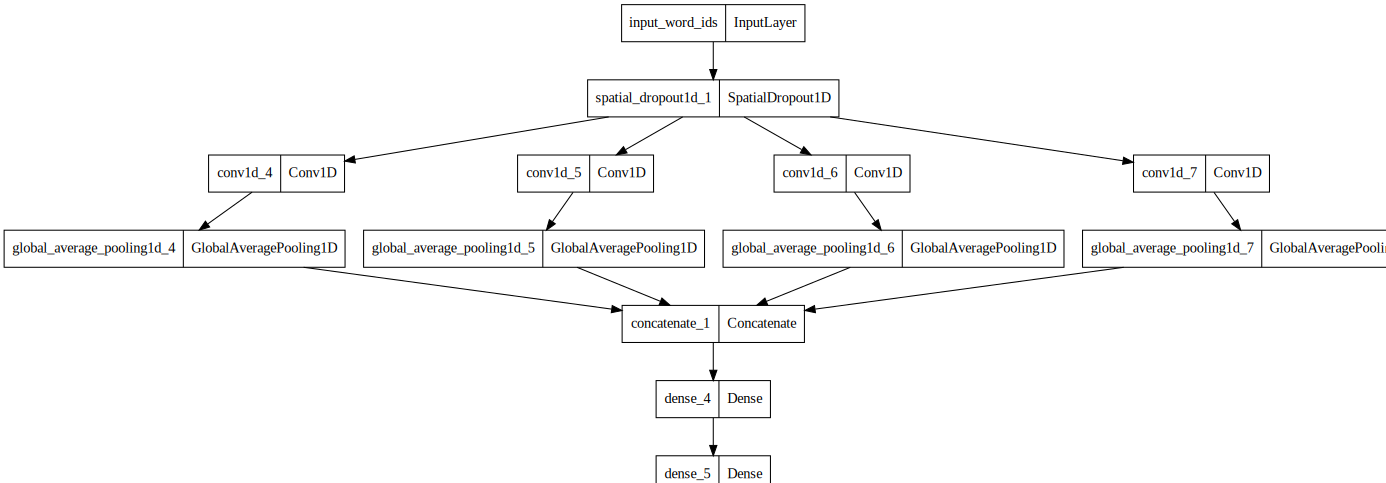

In [ ]:
SVG(tf.keras.utils.model_to_dot(model_cnn, dpi=70).create(prog='dot', format='svg'))

## CNN with More Metrics

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalAveragePooling1D, Dense, SpatialDropout1D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = Precision()
        self.recall = Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * ((p * r) / (p + r + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

def build_cnn_model(transformer, max_len):
    input_word_ids = Input(shape=(max_len, 50), dtype=tf.float32, name="input_word_ids")
    embedding = transformer(input_word_ids) if transformer else input_word_ids
    embedding = SpatialDropout1D(0.3)(embedding)
    conv_layers = [Conv1D(64, size, activation='relu')(embedding) for size in [2, 3, 4, 5]]
    pooled_outputs = [GlobalAveragePooling1D()(conv) for conv in conv_layers]
    conc = concatenate(pooled_outputs, axis=1)
    conc = Dense(64, activation='relu')(conc)
    output = Dense(1, activation='sigmoid')(conc)
    model = Model(inputs=input_word_ids, outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.01),
                  loss='binary_crossentropy',
                  metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), F1Score()])
    return model

model_cnn = build_cnn_model(None, max_len=100)

BATCH_SIZE = 32
N_STEPS = len(x_train) // BATCH_SIZE
EPOCHS = 10

train_history = model_cnn.fit(
    train_dataset,
    steps_per_epoch=N_STEPS,
    validation_data=valid_dataset,
    epochs=EPOCHS
)

results = model_cnn.evaluate(x_test, y_test)
print("Loss: {:.4f}, Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1 Score: {:.4f}".format(*results))

y_pred = model_cnn.predict(x_test)
y_pred_classes = (y_pred > 0.5).astype(int)
conf_matrix = confusion_matrix(y_test, y_pred_classes)
class_report = classification_report(y_test, y_pred_classes)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

Epoch 1/10
1744/1744 [==============================] - 15s 7ms/step - loss: 0.3787 - accuracy: 0.8320 - precision: 0.8239 - recall: 0.7916 - f1_score: 0.8074 - val_loss: 0.2351 - val_accuracy: 0.9046 - val_precision: 0.8540 - val_recall: 0.9504 - val_f1_score: 0.8997
Epoch 2/10
1744/1744 [==============================] - 11s 6ms/step - loss: 0.2586 - accuracy: 0.8945 - precision: 0.8867 - recall: 0.8756 - f1_score: 0.8811 - val_loss: 0.1833 - val_accuracy: 0.9335 - val_precision: 0.9321 - val_recall: 0.9193 - val_f1_score: 0.9256
Epoch 3/10
1744/1744 [==============================] - 11s 6ms/step - loss: 0.2271 - accuracy: 0.9106 - precision: 0.9020 - recall: 0.8973 - f1_score: 0.8997 - val_loss: 0.1618 - val_accuracy: 0.9397 - val_precision: 0.9186 - val_recall: 0.9502 - val_f1_score: 0.9341
Epoch 4/10
1744/1744 [==============================] - 11s 6ms/step - loss: 0.2063 - accuracy: 0.9184 - precision: 0.9118 - recall: 0.9043 - f1_score: 0.9081 - val_loss: 0.1547 - val_accuracy:

### Model Export

In [ ]:
model_path = '/content/drive/My Drive/DS301GroupProject/model_cnn_glove'
model_cnn.save(model_path, save_format='tf')

### Visualize network architecture + data visualization

#### Model Summary

In [ ]:
model_cnn.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_word_ids (InputLayer  [(None, 100, 50)]            0         []                            
 )                                                                                                
                                                                                                  
 spatial_dropout1d_3 (Spati  (None, 100, 50)              0         ['input_word_ids[0][0]']      
 alDropout1D)                                                                                     
                                                                                                  
 conv1d_8 (Conv1D)           (None, 99, 64)               6464      ['spatial_dropout1d_3[0][0]'] 
                                                                                            

#### Model Structure

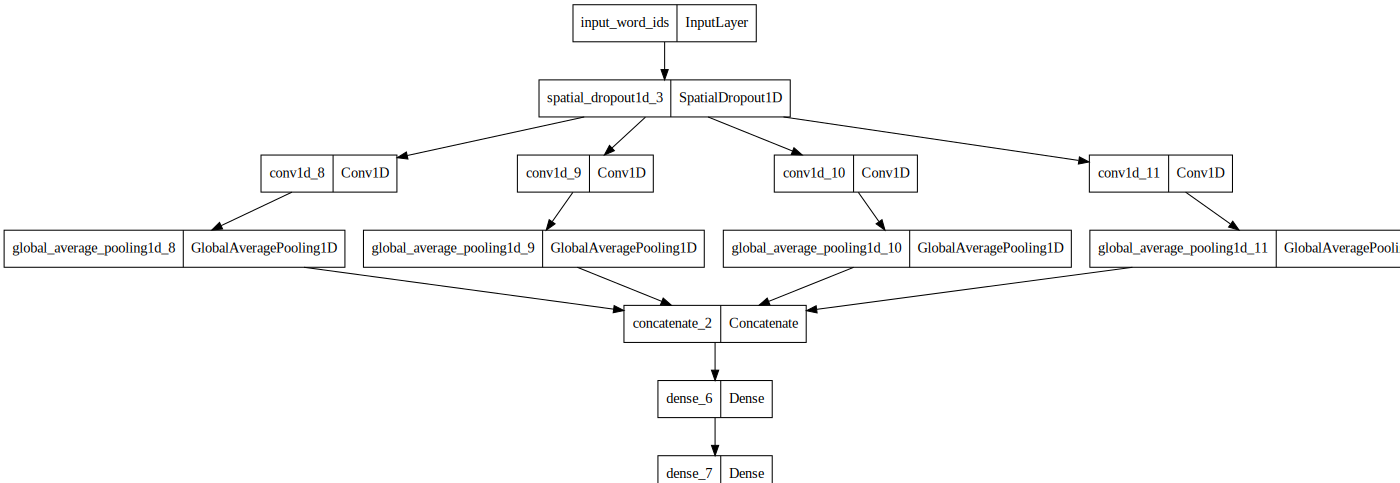

In [ ]:
SVG(tf.keras.utils.model_to_dot(model_cnn, dpi=70).create(prog='dot', format='svg'))

#### AUC ROC

582/582 [==============================] - 2s 3ms/step


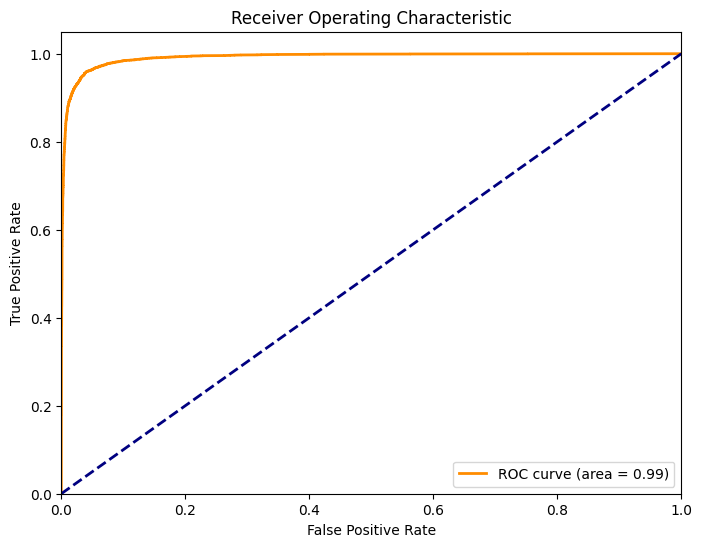

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

y_pred_probs = model_cnn.predict(x_test).ravel()

fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

#### Training and Validation Loss Over Epochs

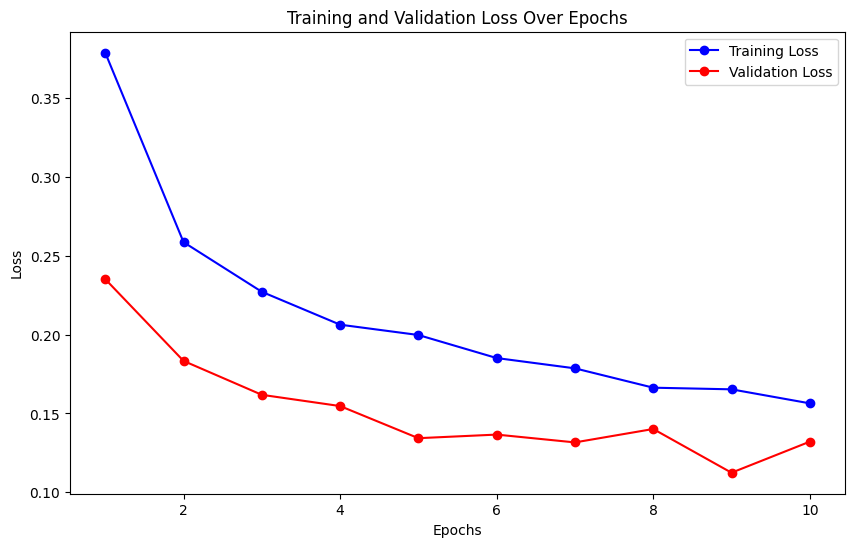

In [ ]:
import matplotlib.pyplot as plt

train_loss = train_history.history['loss']
val_loss = train_history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

#### Training and Validation Accuracy Over Epochs

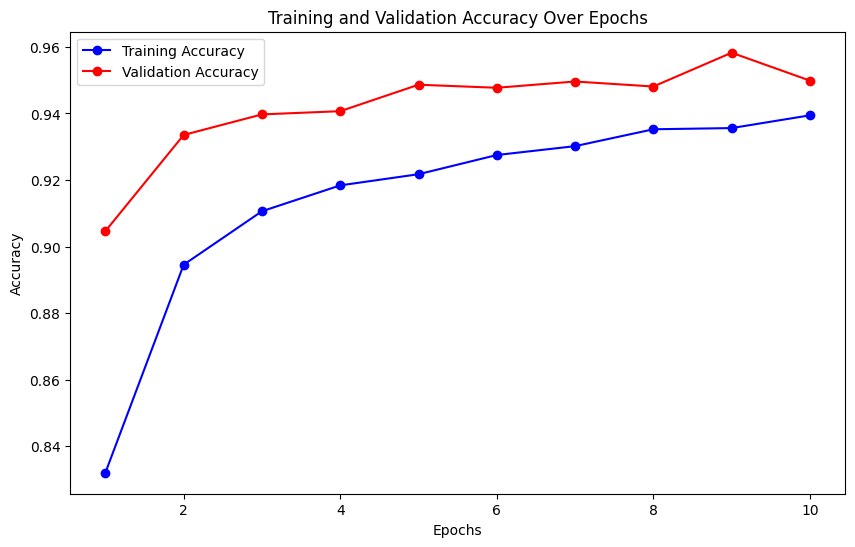

In [ ]:
import matplotlib.pyplot as plt

train_accuracy = train_history.history['accuracy']
val_accuracy = train_history.history['val_accuracy']
epochs = range(1, len(train_accuracy) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### CNN with HyperParameter Tuning

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalAveragePooling1D, Dense, SpatialDropout1D, Concatenate
from tensorflow.keras.optimizers import Adam
from keras_tuner import HyperModel, Hyperband

class CNNHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        input_word_ids = Input(shape=self.input_shape, dtype=tf.float32, name="input_word_ids")
        embedding = SpatialDropout1D(0.3)(input_word_ids)

        for i in range(hp.Int('num_conv_layers', 1, 3)):
            num_filters = hp.Int('filters_' + str(i), min_value=32, max_value=128, step=32)
            kernel_size = hp.Choice('kernel_size_' + str(i), values=[2, 3, 4, 5])
            embedding = Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu')(embedding)

        conc = GlobalAveragePooling1D()(embedding)
        conc = Dense(units=hp.Int('units', min_value=64, max_value=256, step=64), activation='relu')(conc)
        output = Dense(1, activation='sigmoid')(conc)

        model = Model(inputs=input_word_ids, outputs=output)
        model.compile(
            optimizer=Adam(
                hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
            ),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        return model

input_shape = (100, 50)

tuner = Hyperband(
    hypermodel,
    objective='val_accuracy',
    max_epochs=10,
    hyperband_iterations=2,
    directory='hyperband',
    project_name='cnn_tuning'
)

tuner.search(
    x_train, y_train,
    epochs=10,
    validation_data=(x_val, y_val),
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=1)]
)

best_model = tuner.get_best_models(num_models=1)[0]

best_model.evaluate(x_test, y_test)

Trial 60 Complete [00h 01m 04s]
val_accuracy: 0.9515340328216553

Best val_accuracy So Far: 0.9650207161903381
Total elapsed time: 00h 34m 37s
582/582 [==============================] - 2s 2ms/step - loss: 0.0942 - accuracy: 0.9653


[0.0942266583442688, 0.9652893543243408]

In [ ]:
best_model.

In [ ]:
model_path_hyperband = '/content/drive/My Drive/DS301GroupProject/model_cnn_glove_hyperband'
best_model.save(model_path_hyperband, save_format='tf')

### Visualize network architecture + data visualization

#### Model Summary

In [ ]:
best_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_word_ids (InputLayer  [(None, 100, 50)]         0         
 )                                                               
                                                                 
 spatial_dropout1d (Spatial  (None, 100, 50)           0         
 Dropout1D)                                                      
                                                                 
 conv1d (Conv1D)             (None, 98, 96)            14496     
                                                                 
 conv1d_1 (Conv1D)           (None, 95, 64)            24640     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                             

#### Model Structure

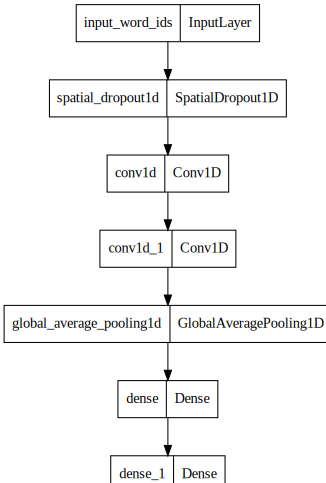

In [ ]:
SVG(tf.keras.utils.model_to_dot(best_model, dpi=70).create(prog='dot', format='svg'))

#### AUC ROC

582/582 [==============================] - 1s 2ms/step


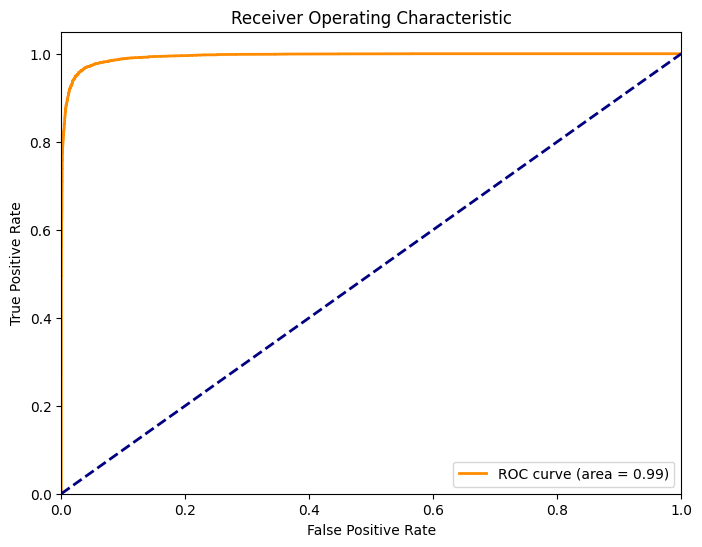

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

y_pred_probs = best_model.predict(x_test).ravel()

fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
best_model.metrics

In [ ]:
model_path = '/content/drive/My Drive/DS301GroupProject/model_cnn_glove'
model_cnn.save(model_path, save_format='tf')

In [ ]:
y_pred = best_model.predict(x_test)
y_pred_classes = (y_pred > 0.5).astype("int32")

conf_matrix = confusion_matrix(y_test, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)
print()

clf_report = classification_report(y_test, y_pred_classes)
print("Classification Report:")
print(clf_report)
print()

loss, accuracy = best_model.evaluate(x_test, y_test)
print("Test Accuracy:", accuracy)

582/582 [==============================] - 1s 2ms/step
Confusion Matrix:
[[10211   305]
 [  341  7754]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     10516
           1       0.96      0.96      0.96      8095

    accuracy                           0.97     18611
   macro avg       0.96      0.96      0.96     18611
weighted avg       0.97      0.97      0.97     18611


582/582 [==============================] - 2s 3ms/step - loss: 0.0942 - accuracy: 0.9653
Test Accuracy: 0.9652893543243408


## Generalization Test

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
file_path = '/content/drive/MyDrive/DS301GroupProject/tweepfake_deepfake_text_detection_test.csv'
datatweep = pd.read_csv(file_path, sep=';')

In [4]:
filtered_datatweep = datatweep.loc[datatweep['class_type'] == 'human', ['text', 'class_type']]
filtered_datatweep.rename(columns={'class_type': 'generated'}, inplace=True)
filtered_datatweep['generated'] = 0
filtered_datatweep

,text,generated
0,justin timberlake really one of the goats if y...,0
1,Thank you @PMBhutan for your gracious prayers ...,0
2,Theory: the number of red lights you will hit ...,0
4,Might give the BASIC #10Liner game contest ano...,0
7,I Wanna See Some Rainbows Out There Boys,0
...,...,...
2550,Took stock of the situation in the wake of cyc...,0
2552,"#NowPlaying ""Uno Dos (feat. Jaden)"" by ¿Téo? i...",0
2554,Love the Choose your own adventure style of th...,0
2556,These deeply discounted 256GB SanDisk flash dr...,0


In [5]:
file_path2 = '/content/drive/MyDrive/DS301GroupProject/train_essays_v1.csv'
gemini = pd.read_csv(file_path2, sep=';')
gemini.rename(columns={'text,label,prompt_name,source,RDizzl3_seven': 'text'}, inplace=True)
gemini['generated'] = 1
gemini

,text,generated
0,The Electoral College is a complex system that...,1
1,"The exploration of Venus, Earth's closest plan...",1
2,## Does the Electoral College Work?\n\nThe Ele...,1
3,"In the vast realm of literature, there exists ...",1
4,"In the realm of modern transportation, the adv...",1
...,...,...
3495,"The Electoral College, a distinctive feature o...",1
3496,The Electoral College is a system of indirect ...,1
3497,"The electoral College, an integral part of the...",1
3498,"The Electoral College, a distinctive feature o...",1


In [6]:
gemini_test_df = pd.concat([filtered_datatweep, gemini], ignore_index=True)
gemini_test_df

,text,generated
0,justin timberlake really one of the goats if y...,0
1,Thank you @PMBhutan for your gracious prayers ...,0
2,Theory: the number of red lights you will hit ...,0
3,Might give the BASIC #10Liner game contest ano...,0
4,I Wanna See Some Rainbows Out There Boys,0
...,...,...
4773,"The Electoral College, a distinctive feature o...",1
4774,The Electoral College is a system of indirect ...,1
4775,"The electoral College, an integral part of the...",1
4776,"The Electoral College, a distinctive feature o...",1


In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer(num_words=10000)
features = gemini_test_df['text'].values
tokenizer.fit_on_texts(features)
sequences = tokenizer.texts_to_sequences(features)
max_len = 512
padded_sequences_gemini = pad_sequences(sequences, maxlen=max_len, padding='post')
labels_gemini = gemini_test_df['generated'].values
print("Padded Sequences Shape:", padded_sequences_gemini.shape)
print("Labels Shape:", labels_gemini.shape)
test_dataset_gemini = tf.data.Dataset.from_tensor_slices((padded_sequences_gemini, labels_gemini)).batch(32)

Padded Sequences Shape: (4778, 512)
Labels Shape: (4778,)


In [9]:
import numpy as np
sequence_lengths = [len(seq) for seq in sequences]
print("Average sequence length:", np.mean(sequence_lengths))
print("Max sequence length:", np.max(sequence_lengths))

padded_sequences = pad_sequences(sequences, maxlen=300, padding='post')

Average sequence length: 396.762452909167
Max sequence length: 874


In [ ]:
model_fnn_path = '/content/drive/My Drive/DS301GroupProject/model_fnn'
model_cnn_path = '/content/drive/My Drive/DS301GroupProject/model_cnn'

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.backend import clear_session
clear_session()
model_cnn = load_model(model_fnn_path)
clear_session()
model_capsule = load_model(model_cnn_path)

In [ ]:
loss_fnn, accuracy_fnn = model_cnn.evaluate(test_dataset_gemini)
loss_cnn, accuracy_cnn = model_capsule.evaluate(test_dataset_gemini)

print("FNN Model Test Accuracy:", accuracy_fnn)
print("CNN with best parameter Test Accuracy:", accuracy_cnn)

291/291 [==============================] - 12s 40ms/step - loss: 0.2991 - accuracy: 0.8852
CNN Model Test Accuracy: 0.8728171586990356
Capsule Model Test Accuracy: 0.8852291703224182
